In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
import gym
from IPython.display import clear_output

## NN 설정 Policy Gradient
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)  # Prob of left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.axhline(y=200,linestyle ='--')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  

## Hyperparameter
num_episode = 500
batch_size = 5
learning_rate = 0.01
gamma = 0.99


episode_durations = []


env = gym.make('CartPole-v0').unwrapped

## Policy network 설정
policy_net = PolicyNet()
target_net = PolicyNet()

## Optimizer 종류
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)

## State,Action,Reward를 저장할 List
state_pool = []
action_pool = []
reward_pool = []
steps = 0

## Traing 부분이지만 이 속에서 학습을 한다 
## On-policy 
for e in range(num_episode):

    ## State를 Tensor로 바꿔서 이용
    state = env.reset()
    state = torch.FloatTensor(state)
    state = Variable(state)

    
    ## 에피소드 시작
    for t in count():
        ## Action을 선택하기 위해 이항분포 => Discrete Action space
        probs = policy_net(state)
        m = Bernoulli(probs)
        action = m.sample()
        action = action.data.numpy().astype(int)[0]
        next_state, reward, done, _ = env.step(action)

        ## 끝나면 Reward를 0으로 줘서 에피소드마다 구분지음
        if done :
            reward = 0
        ## Trajectory 저장 / Experience Replay와 다르게 현재 Trajectory를 저장한다.
        state_pool.append(state)
        action_pool.append(float(action))
        reward_pool.append(reward)
        state = next_state
        state = torch.from_numpy(state).float()
        state = Variable(state)

        steps += 1

        if done or t > 500:
            episode_durations.append(t + 1)
            plot_durations()
            break
    ## On - policy 이기 때문에 에피소드 스탭 속에서 학습
    ## Update policy / Batch_size 만큼 지났을 때 학습을 시작한다.
    if e > 0 and e % batch_size == 0:

        ## Discount reward
        running_add = 0
        for i in reversed(range(steps)):
            ## Reward == 0 이 에피소드마다 구분 짓는곳
            if reward_pool[i] == 0:
                running_add = 0
            else:
                running_add = running_add * gamma + reward_pool[i]
                reward_pool[i] = running_add

        ## Reward 표준화 
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(steps):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        ## Gradient Descent
        optimizer.zero_grad()

        ## 현재 에피소드의 Step을 통해 loss 계산
        for i in range(steps):
            state = state_pool[i]
            action = Variable(torch .FloatTensor([action_pool[i]]))
            reward = reward_pool[i]

            probs = policy_net(state)
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward  ## Negtive score function x reward
            loss.backward()
        
        ## Optimize
        optimizer.step()
        
        ## Trajectory 다시 초기화
        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0
    
    if num_episode % 50 ==0 :
        clear_output()
        
        
        
target_net.load_state_dict(policy_net.state_dict())
plot_durations()


<Figure size 640x480 with 1 Axes>

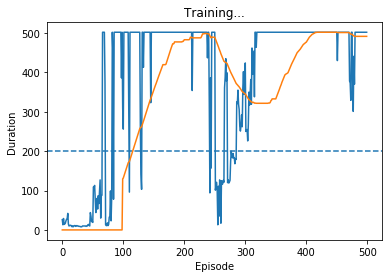

In [2]:
plot_durations()

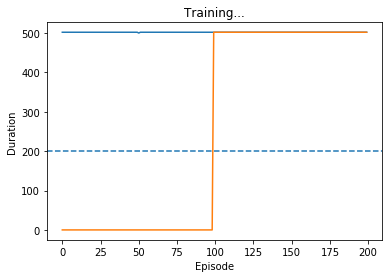

In [3]:
num_episode = 200
episode_durations1 = []

def plot_durations1():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations1)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.axhline(y=200,linestyle ='--')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)



for e in range(num_episode):

    ## State를 Tensor로 바꿔서 이용
    state = env.reset()
    state = torch.from_numpy(state).float()
    state = Variable(state)

    
    ## 에피소드 시작
    for t in count():
        ## Action을 선택하기 위해 이항분포 => Discrete Action space
        probs = target_net(state)
        m = Bernoulli(probs)
        action = m.sample()
        action = action.data.numpy().astype(int)[0]
        next_state, reward, done, _ = env.step(action)

        state = next_state
        state = torch.from_numpy(state).float()
        state = Variable(state)


        if done or t > 500:
            episode_durations1.append(t + 1)
            break
    
    
plot_durations1()

Comments : 500번의 에피소드를 통해 학습을 한 결과로 연산이 적기 때문에 Off - Policy 방법들 보다는 확실히 빠르다. 또한 결과에도 Oscillation없이 좋은 결과를 보인다. Action Dimension이 크거나 연속적인 환경에서 적합하다.